## Imports

In [1]:
import os
import tarfile
import urllib
from scipy import stats

import pandas as pd
from pandas import DataFrame, Series
from pandas.plotting import scatter_matrix

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

# Data
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV, StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict

# Transformation
# ADASYN | RandomOverSampler | KMeansSMOTE | SMOTE | BorderlineSMOTE | SVMSMOTE | SMOTENC | SMOTEN
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Dimensionality Reduction
from sklearn.decomposition import PCA

from sklearn.linear_model import LinearRegression, LogisticRegressionCV, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

# Metrics
from sklearn.metrics import r2_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve, precision_score, recall_score, f1_score, average_precision_score

## Data Loading

In [2]:
df = pd.read_csv("../../../datasets/raw/bone_marrow_raw.csv")
df.convert_dtypes()

,donor_age,donor_age_below_35,donor_ABO,donor_CMV,recipient_age,recipient_age_below_10,recipient_age_int,recipient_gender,recipient_body_mass,recipient_ABO,...,CD3_to_CD34_ratio,ANC_recovery,PLT_recovery,acute_GvHD_II_III_IV,acute_GvHD_III_IV,time_to_acute_GvHD_III_IV,extensive_chronic_GvHD,relapse,survival_time,survival_status
0,22.830137,yes,A,present,9.6,yes,5_10,male,35.0,A,...,1.33876,19,51,yes,yes,32,no,no,999,0
1,23.342466,yes,B,absent,4.0,yes,0_5,male,20.6,B,...,11.078295,16,37,yes,no,1000000,no,yes,163,1
2,26.394521,yes,B,absent,6.6,yes,5_10,male,23.4,B,...,19.01323,23,20,yes,no,1000000,no,yes,435,1
3,39.684932,no,A,present,18.1,no,10_20,female,50.0,AB,...,29.481647,23,29,yes,yes,19,?,no,53,1
4,33.358904,yes,A,absent,1.3,yes,0_5,female,9.0,AB,...,3.972255,14,14,no,no,1000000,no,no,2043,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,37.575342,no,A,present,12.9,no,10_20,male,44.0,A,...,2.52275,15,22,yes,yes,16,no,yes,385,1
183,22.89589,yes,A,absent,13.9,no,10_20,female,44.5,0,...,1.038858,12,30,no,no,1000000,no,no,634,1
184,27.347945,yes,A,present,10.4,no,10_20,female,33.0,B,...,1.635559,16,16,yes,no,1000000,no,no,1895,0
185,27.780822,yes,A,absent,8.0,yes,5_10,male,24.0,0,...,8.07777,13,14,yes,yes,54,yes,no,382,1


## Data Manipulation

- Remove unwanted features
- Rename attributes
- Reorder attributes

In [3]:
df["donor_age_group"] = pd.cut(df["donor_age"], bins=[18., 35., 50., 60.], labels=["18-35", "35-50", "50-60"])

In [4]:
df = df.drop(columns=["survival_time", "survival_status",
                      "recipient_age_int", "recipient_rh", "HLA_group_1", "ANC_recovery", "PLT_recovery",
                      "acute_GvHD_II_III_IV", "acute_GvHD_III_IV", "time_to_acute_GvHD_III_IV", "extensive_chronic_GvHD"])

df.columns

Index(['donor_age', 'donor_age_below_35', 'donor_ABO', 'donor_CMV',
       'recipient_age', 'recipient_age_below_10', 'recipient_gender',
       'recipient_body_mass', 'recipient_ABO', 'recipient_CMV', 'disease',
       'disease_group', 'gender_match', 'ABO_match', 'CMV_status', 'HLA_match',
       'HLA_mismatch', 'antigen', 'allel', 'risk_group', 'stem_cell_source',
       'tx_post_relapse', 'CD34_x1e6_per_kg', 'CD3_x1e8_per_kg',
       'CD3_to_CD34_ratio', 'relapse', 'donor_age_group'],
      dtype='object')

In [5]:
df.rename(columns={"allel": "allels_incompatible",
                   "antigen": "antigens_incompatible",
                   "HLA_match": "HLA_score",
                   "HLA_mismatch": "HLA_match",
                   "CMV_status": "CMV_serostatus",
                   "CD34_x1e6_per_kg": "CD34_per_kg", 
                   "CD3_x1e8_per_kg": "CD3_per_kg",
                   "CD3_to_CD34_ratio": "CD3_CD34_ratio",
                   "tx_post_relapse": "transplant_repeat",
                   "disease_group": "malignant_disease"}, inplace=True)

df.columns

Index(['donor_age', 'donor_age_below_35', 'donor_ABO', 'donor_CMV',
       'recipient_age', 'recipient_age_below_10', 'recipient_gender',
       'recipient_body_mass', 'recipient_ABO', 'recipient_CMV', 'disease',
       'malignant_disease', 'gender_match', 'ABO_match', 'CMV_serostatus',
       'HLA_score', 'HLA_match', 'antigens_incompatible',
       'allels_incompatible', 'risk_group', 'stem_cell_source',
       'transplant_repeat', 'CD34_per_kg', 'CD3_per_kg', 'CD3_CD34_ratio',
       'relapse', 'donor_age_group'],
      dtype='object')

In [6]:
df = df.loc[:, ["donor_age_group", "donor_age", "donor_age_below_35", "donor_CMV", "donor_ABO",
                 "recipient_age", "recipient_age_below_10", "recipient_CMV", "recipient_ABO", "recipient_gender", "recipient_body_mass",
                 "disease", "malignant_disease",
                 "CMV_serostatus", "ABO_match", "gender_match", "HLA_score", "HLA_match", "antigens_incompatible", "allels_incompatible",
                 "risk_group", "stem_cell_source", "transplant_repeat",
                 "CD34_per_kg", "CD3_per_kg", "CD3_CD34_ratio",
                 "relapse"]]

## TT Split

- Split data using relapse strata


In [7]:
split = StratifiedShuffleSplit(1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(df, df["relapse"]):
    train_set: DataFrame = df.loc[train_index]
    test_set: DataFrame = df.loc[test_index]

In [8]:
data = train_set.drop(labels=["relapse"], axis=1)
data_label = train_set["relapse"].map({"no": 0, "yes": 1})

## Data Preparation Pipeline

- Remove duplicates
- Handle missing values
- Encode features

In [9]:
def encode_booleans(data: DataFrame):
    zero_mapper = {"absent", "no", "female", "mismatched", "female_to_male", "low", "nonmalignant", "peripheral_blood", "?"}
    one_mapper  = {"present", "yes", "male", "matched", "other", "high", "malignant", "bone_marrow"}

    def map_values(value):
        if value in zero_mapper:
            return 0
        if value in one_mapper:
            return 1
        
        return value

    return data.map(map_values)

In [10]:
class MissingAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X: DataFrame):
        X = X.copy()
        X["donor_CMV_missing"] = (X["donor_CMV"] == "?").astype(int)
        X["recipient_CMV_missing"] = (X["recipient_CMV"] == "?").astype(int)

        X["ABO_match_missing"] = (X["ABO_match"] == "?").astype(int)
        return X

In [11]:
def impute_body_mass(data: DataFrame):
    data = data.copy()

    data["recipient_age_group"] = pd.cut(data["recipient_age"], bins=[0., 1., 5., 10., 15., 20., np.inf], labels=["<1", "1-5", "5-10", "10-15", "15-20", "20+"])

    group_median = data.groupby(["recipient_gender", "recipient_age_group"])["recipient_body_mass"].median()

    def fill_mass(row):
        if pd.isna(row["recipient_body_mass"]):
            return group_median.get((row["recipient_gender"], row["recipient_age_group"]), data["recipient_body_mass"].median())
        return row["recipient_body_mass"]

    data["recipient_body_mass"] = data.apply(fill_mass, axis=1)

    data = data.drop(columns="recipient_age_group")
    return data

In [12]:
def impute_cell_dosage(data: DataFrame):
    data = data.copy()

    train_data = data.dropna(subset=["CD3_per_kg", "CD34_per_kg"])

    linear_reg = LinearRegression()
    linear_reg.fit(train_data[["CD34_per_kg", "recipient_body_mass"]], train_data["CD3_per_kg"])

    missing_CD3_data = data["CD3_per_kg"].isna()
    data.loc[missing_CD3_data, "CD3_per_kg"] = linear_reg.predict(data.loc[missing_CD3_data, ["CD34_per_kg", "recipient_body_mass"]])

    data.loc[data["CD3_CD34_ratio"].isna(), "CD3_CD34_ratio"] = data["CD3_per_kg"] / data["CD34_per_kg"]

    return data


In [13]:
bool_attribs = ["donor_age_below_35", "donor_CMV", "recipient_age_below_10", "recipient_CMV", "recipient_gender", "malignant_disease", "ABO_match",
                "gender_match", "HLA_match", "risk_group", "stem_cell_source", "transplant_repeat"]

nominal_attribs = ["donor_ABO", "recipient_ABO", "disease", "CMV_serostatus"]

ordinal_attribs = ["donor_age_group", "HLA_score"]

ordinal_cats = [["18-35", "35-50", "50-60"],
                ["7/10", "8/10", "9/10", "10/10"]]

num_attribs = ["donor_age", "recipient_age", "recipient_body_mass", "antigens_incompatible",
               "allels_incompatible", "CD34_per_kg", "CD3_per_kg", "CD3_CD34_ratio"]

In [14]:
num_imputing = Pipeline([
    ("body_mass_imputer", FunctionTransformer(impute_body_mass, validate=False)),
    ("cell_dosage_imputer", FunctionTransformer(impute_cell_dosage, validate=False)),
])

cat_encoding = ColumnTransformer([
    ("bool_encoder", FunctionTransformer(encode_booleans, validate=False), bool_attribs),
    ("nom_encoder", OneHotEncoder(), nominal_attribs),
    ("ord_encoder", OrdinalEncoder(categories=ordinal_cats), ordinal_attribs),
])

preprocessing = Pipeline([
    ("num_imputing", num_imputing),
    ("cat_encoding", cat_encoding),
    ("std_scaler", StandardScaler()),
])

data_preparation_pipeline = Pipeline([
    ("dupes_clean", FunctionTransformer(lambda data: data.drop_duplicates(), validate=False)),
    ("construct", MissingAttributesAdder()),
    ("preprocess", preprocessing),
])

data_prepared = data_preparation_pipeline.fit_transform(data)

C:\Users\rikis\AppData\Local\Temp\ipykernel_14876\3503495110.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_median = data.groupby(["recipient_gender", "recipient_age_group"])["recipient_body_mass"].median()


## Oversampling

In [15]:
ros = RandomOverSampler(random_state=42)
data_resampled_ros, label_resampled_ros = ros.fit_resample(data_prepared, data_label)

print(label_resampled_ros.value_counts())

relapse
0    127
1    127
Name: count, dtype: int64


In [16]:
smote = SMOTE(random_state=42)
data_resampled_smote, label_resampled_smote = smote.fit_resample(data_prepared, data_label)

print(label_resampled_smote.value_counts())

relapse
0    127
1    127
Name: count, dtype: int64


In [17]:
ada = ADASYN(random_state=42)
data_resampled_ada, label_resampled_ada = ada.fit_resample(data_prepared, data_label)

print(label_resampled_ada.value_counts())

relapse
1    128
0    127
Name: count, dtype: int64


In [18]:
X_resampled = {
    "ros": data_resampled_ros,
    "smote": data_resampled_smote,
    "ada": data_resampled_ada
}

y_resampled = {
    "ros": label_resampled_ros,
    "smote": label_resampled_smote,
    "ada": label_resampled_ada
}

## Model Search

In [19]:
def display_metrics(y, y_pred, y_prob):

    # Confusion Matrix
    fig, ax = plt.subplots(figsize=(5, 5))
    cmatrix = confusion_matrix(y, y_pred)
    cmatrix_disp = ConfusionMatrixDisplay(
        confusion_matrix=cmatrix,
        display_labels=["no", "yes"]
    )
    cmatrix_disp.plot(ax=ax)
    plt.show()

    # ROC Curve
    fig, ax = plt.subplots(figsize=(5, 5))
    fpr, tpr, _ = roc_curve(y, y_prob[:, 1])
    roc_auc = auc(fpr, tpr)

    ax.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    ax.plot([0, 1], [0, 1], linestyle="--")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend()
    plt.show()

    # Precision-Recall Curve
    fig, ax = plt.subplots(figsize=(5, 5))
    precision, recall, _ = precision_recall_curve(y, y_prob[:, 1])
    pr_auc = average_precision_score(y, y_prob[:, 1])

    ax.plot(recall, precision, label=f"AP = {pr_auc:.3f}")
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.legend()
    plt.show()

    # General Metrics
    p = precision_score(y, y_pred)
    r = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)

    print(f"Precision: {p:.3f}")
    print(f"   Recall: {r:.3f}")
    print(f" f1-score: {f1:.3f}")


In [ ]:
models = {
    "log_reg": LogisticRegressionCV(),
    "rand_forest": RandomForestClassifier(),
    "ada_boost": AdaBoostClassifier()
}

param_grid = {
    "log_reg": {
        "scoring": [None, "recall"],
        "solver": ["lbfgs", "liblinear", "saga"],
        "max_iter": [1],
        "class_weight": [None, "balanced"],
    },
    "rand_forest": {
        "n_estimators": [100],
        "criterion": ["gini", "entropy"],
        "max_depth": [10, 30],
        "min_samples_split": [3, 5, 7],
        "bootstrap": [False, True],
        "class_weight": [None, "balanced"],
        "max_features": [None, "sqrt", "log2"],
    },
    "ada_boost": {
        "estimator": [None],
        "n_estimators": [20, 30, 50],
        "learning_rate": [0.05, 0.2, 0.5, 1.0],
        "algorithm": ["SAMME", "SAMME.R"],
    }
}

In [38]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(models["log_reg"], param_grid["log_reg"], scoring="recall", cv=cv, n_jobs=-1)

grid_search.fit(X_resampled["smote"], y_resampled["smote"])

C:\Users\rikis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\rikis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\rikis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\rikis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear 

,estimator,LogisticRegressionCV()
,param_grid,"{'class_weight': [None, 'balanced'], 'max_iter': [5], 'scoring': [None, 'recall'], 'solver': ['lbfgs', 'liblinear', ...]}"
,scoring,'recall'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,Cs,10


C:\Users\rikis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\rikis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\rikis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\rikis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear 

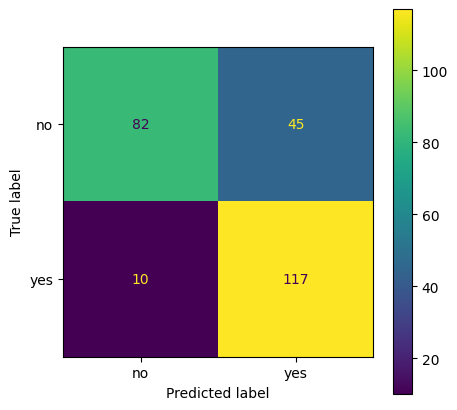

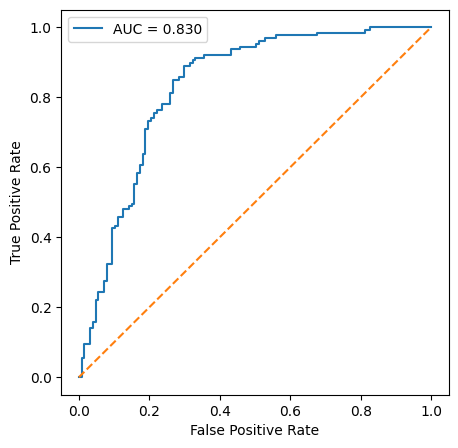

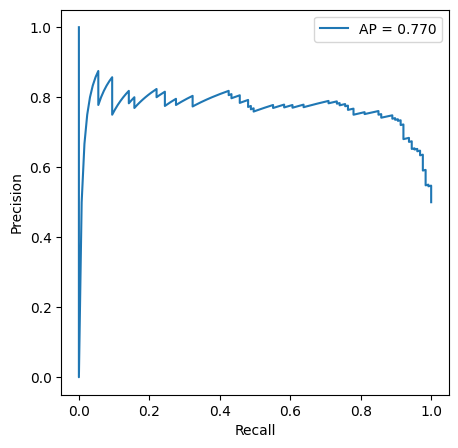

Precision: 0.722
   Recall: 0.921
 f1-score: 0.810


In [39]:
model = grid_search.best_estimator_

y_pred = cross_val_predict(model, X_resampled["smote"], y_resampled["smote"], cv=cv)
y_prob = cross_val_predict(model, X_resampled["smote"], y_resampled["smote"], cv=cv, method="predict_proba")

display_metrics(y_resampled["smote"], y_pred, y_prob)

In [ ]:
grid_search = GridSearchCV(models["rand_forest"], param_grid["rand_forest"], scoring="recall", cv=cv, n_jobs=-1)

grid_search.fit(X_resampled["smote"], y_resampled["smote"])

In [ ]:
model = grid_search.best_estimator_

y_pred = cross_val_predict(model, X_resampled["smote"], y_resampled["smote"], cv=cv)
y_prob = cross_val_predict(model, X_resampled["smote"], y_resampled["smote"], cv=cv, method="predict_proba")

display_metrics(y_resampled["smote"], y_pred, y_prob)

In [ ]:
grid_search = GridSearchCV(models["ada_boost"], param_grid["ada_boost"], scoring="recall", cv=cv, n_jobs=-1)

grid_search.fit(X_resampled["smote"], y_resampled["smote"])

In [ ]:
model = grid_search.best_estimator_

y_pred = cross_val_predict(model, X_resampled["smote"], y_resampled["smote"], cv=cv)
y_prob = cross_val_predict(model, X_resampled["smote"], y_resampled["smote"], cv=cv, method="predict_proba")

display_metrics(y_resampled["smote"], y_pred, y_prob)

## Model Score (w/ test data)

C:\Users\rikis\AppData\Local\Temp\ipykernel_14876\3503495110.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_median = data.groupby(["recipient_gender", "recipient_age_group"])["recipient_body_mass"].median()


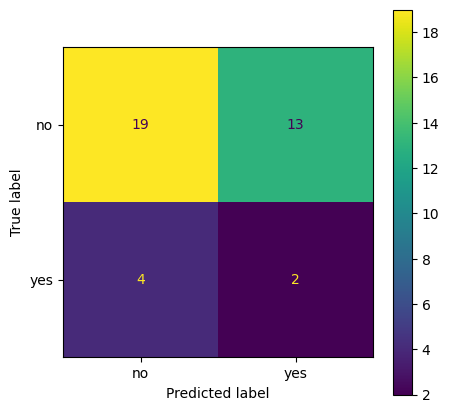

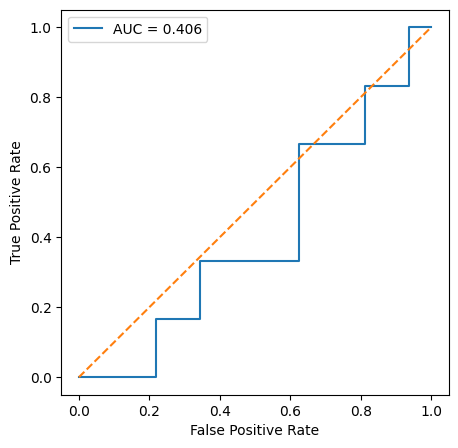

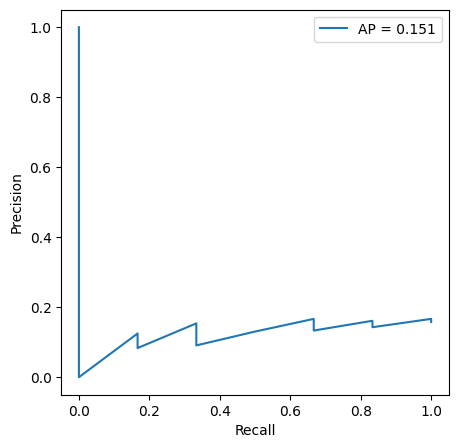

Precision: 0.133
   Recall: 0.333
 f1-score: 0.190


In [36]:
X_test = test_set.drop(labels=["relapse"], axis=1).copy()
y_test = test_set["relapse"].map({"no": 0, "yes": 1}).copy()

X_test_prep = data_preparation_pipeline.transform(X_test)

y_pred = model.predict(X_test_prep)
y_prob = model.predict_proba(X_test_prep)

display_metrics(y_test, y_pred, y_prob)